## Load the dataset

In [2]:
%cd /content/drive/MyDrive/IT4868/Experiment/L07-ÌE
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head(30)

/content/drive/.shortcut-targets-by-id/1CIfBwkgzyZvFDkCWib8Kv7qIBJT018ow/IT4868/Experiment/L07-ÌE


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [3]:
data.shape

(1048575, 4)

In [4]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [5]:
data ['Word_idx'] = data ['Word']. map (token2idx) 
data ['Tag_idx'] = data ['Tag']. map (tag2idx) 
data.head ()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,32381,3
1,NaN,of,IN,O,4851,3
2,NaN,demonstrators,NNS,O,12036,3
3,NaN,have,VBP,O,3706,3
4,NaN,marched,VBN,O,31795,3


In [6]:
# Fill na
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[32381, 4851, 12036, 3706, 31795, 9784, 34392,...","[3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[7827, 15262, 7429, 25355, 843, 7572, 24552, 5...","[13, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[3155, 14077, 2493, 19947, 19692, 24672, 16005...","[3, 3, 16, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 15..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[29869, 23138, 1086, 17649, 6410, 9067, 17790,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[3497, 4052, 33857, 1684, 564, 12922, 23472, 2...","[1, 3, 3, 14, 0, 3, 16, 3, 1, 3, 13, 3, 13, 3,..."


In [ ]:
df.groupby('Tag').size().reset_index(name='counts')

## Split the dataset into train, test 

In [7]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [9]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)


train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


## Build the model architecture

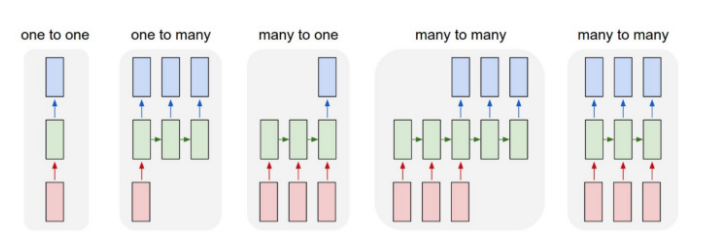

In [10]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

Model architecture

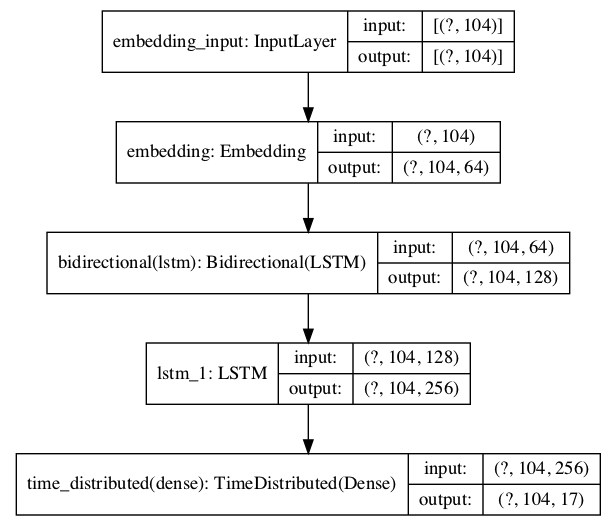

In [11]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17


In [13]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
number_epoch = 25
def train_model(X, y, model):
    loss = list()
    for i in range(number_epoch):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [ ]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
26/26 [==============================] - 139s 5s/step - loss: 0.0927 - accuracy: 0.9690 - val_loss: 0.1086 - val_accuracy: 0.9693


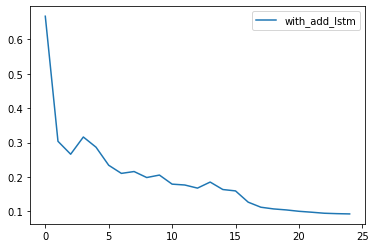

In [ ]:
# line plot of results
results.plot()